# Sentence Classification


Lien vers le dataset https://www.kaggle.com/datasets/sheikhsharfuddinmim/nlpgettingstarted?select=test.csv 


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
from torchtext import data
import torch.nn as nn
from torchtext.data.utils import get_tokenizer



In [74]:
# Import Data

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

## **Data Pre Processing**
Cleaning the text data 

In [75]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [76]:
# Shape of dataset
train.shape

(7613, 5)

In [77]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### The `target` column marks the label of the text:
* **
* **label==1** : If the Tweet is about Disasters.
* **label==0** : If the Tweet is not about disasters. 


In [6]:
# drop 'id' , 'keyword' and 'location' columns.
train.drop(columns=['id','keyword','location'], inplace=True)

### Ensuite, nous nettoyons et modifions les textes, afin que l'algorithme de classification ne soit pas confondu avec des informations non pertinentes.

In [7]:
# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [8]:
train["text"]=normalise_text(train["text"])

In [9]:
train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

Split the data into training and validation sets

In [10]:
# split data into train and validation 
train_df, valid_df = train_test_split(train)


In [11]:
train_df.head()

,text,target
3088,omar_molina036 milioooo_ he's trying to electr...,0
3440,im dead!!! my two loves in 1 photo! my heart e...,0
5809,fa07af174a71408 i have lived &amp; my family h...,1
5577,landslide caused by severe rainstorm kills 3 i...,1
4689,speaking of memorable debates: 60-second know-...,0


In [12]:
valid_df.head()

,text,target
4557,#golf mcilroy fuels pga speculation after vide...,0
6517,16 stylishly unique houses that might help you...,0
4530,and you wonder why he's injured every year htt...,0
6601,#politics democracyûªs hatred for hate: û_ d...,1
2698,ignition knock (detonation) sensor-senso stand...,0


The following will help make the results reproducible later.


In [13]:
# Définir une graine (SEED) pour assurer la reproductibilité des résultats
SEED = 42

# Fixer la graine pour la génération de nombres aléatoires par PyTorch (CPU)
torch.manual_seed(SEED)

# Fixer la déterministicité de l'algorithme de convolution CUDA (cuDNN) pour la reproductibilité (GPU)
torch.backends.cudnn.deterministic = True

# Désactiver l'optimisation automatique de cuDNN qui peut accélérer l'exécution, mais peut ne pas être reproductible
torch.backends.cudnn.benchmark = False


Nous devons créer des objets « Field » pour traiter les données texte. Ces objets de champ contiendront des informations pour convertir les textes en Tensors.
Nous définirons deux paramètres :
* `tokenize=spacy` et
* `include_arguments=Vrai`
Ce qui implique que SpaCy sera utilisé pour tokeniser les textes et que les objets de champ doivent inclure la longueur des textes - ce qui sera nécessaire pour remplir les textes.
Nous utiliserons plus tard les méthodes de ces objets pour créer un vocabulaire, qui nous aidera à créer une représentation numérique pour chaque jeton.

Le `LabelField` est un champ enveloppant peu profond, utile pour les étiquettes de données.

In [14]:
import spacy

# Load the spaCy model using its full name
spacy_model_name = "en_core_web_sm"
spacy_model = spacy.load(spacy_model_name)

# Define your fields
TEXT = data.Field(tokenize=get_tokenizer("spacy", language=spacy_model_name), include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)


Ensuite, nous créons une classe `DataFrameDataset` qui nous permettra de charger les données et les étiquettes cibles en tant que `DataSet` en utilisant un DataFrame comme source de données.
Nous créerons un vocabulaire à l'aide de l'ensemble de données de formation, puis transmettrons ultérieurement les ensembles de données de formation et de validation à l'itérateur.

In [15]:
class DataFrameDataset(data.Dataset):

    # Initialiser la classe avec un DataFrame, les champs de données, et d'autres paramètres
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        
        # Itérer sur les lignes du DataFrame
        for i, row in df.iterrows():
            # Extraire la cible (label) à partir de la colonne 'target', ou laisser None si c'est un ensemble de test
            label = row.target if not is_test else None
            # Extraire le texte à partir de la colonne 'text'
            text = row.text
            # Créer un exemple à partir des données extraites et ajouter à la liste d'exemples
            examples.append(data.Example.fromlist([text, label], fields))

        # Appeler le constructeur de la classe parent (torchtext.data.Dataset) avec les exemples et les champs
        super().__init__(examples, fields, **kwargs)

    # Définir une clé de tri pour trier les exemples en fonction de la longueur du texte
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    # Méthode de classe pour créer des ensembles de données à partir de DataFrames
    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        # Créer des ensembles de données pour l'entraînement, la validation et le test, si les DataFrames sont fournis
        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        # Retourner les ensembles de données non nuls
        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


* Nous allons d'abord créer une liste appelée _field_, où les éléments seront un tuple de chaîne (nom) et d'objet `Field`. L'objet `Field` pour le texte doit être placé avec le nom 'text' et l'objet pour l'étiquette doit être placé avec le nom 'label'

Ensuite, nous utiliserons la méthode `splits` de `DataFrameDataset`, qui renverra les ensembles de données de formation et de validation, qui seront composés d'exemples de textes et d'étiquettes tokenisés. Les textes et étiquettes porteront le nom que nous donnons au _champ_.

In [16]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [17]:
# Lets look at a random example
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))

{'text': ['have', 'you', 'ever', 'remembered', 'an', 'old', 'song', 'something', 'you', 'have', "n't", 'heared', 'for', 'years', '?', ' ', 'words', 'that', 'carry', 'floods', 'of', 'memories', 'all', 'along', '.', '#', 'priceless'], 'label': 0}
<class 'torchtext.data.example.Example'>


Nous allons maintenant construire le vocabulaire en utilisant uniquement le jeu de données d'entraînement. Il est accessible via `TEXT.vocab` et sera partagé avec l'ensemble de données de validation.

Nous utiliserons des vecteurs pré-entraînés de 200 dimensions pour représenter les mots. Tout token inconnu aura un vecteur nul. Ces vecteurs seront chargés ultérieurement en tant que couche d'intégration. 

In [223]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)



In [224]:
LABEL.build_vocab(train_ds)

We build the iterators. 

In [225]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## LSTM architecture

### Declare Hyperparameters

In [259]:
num_epochs = 5

learning_rate = 0.01
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 128 # Dimension cachée du modèle RNN
OUTPUT_DIM = 1 # Dimension de sortie du modèle
N_LAYERS = 2 # Nombre de couches du modèle RNN
BIDIRECTIONAL = True # Indique si le modèle RNN est bidirectionnel
DROPOUT = 0.2 # Taux de dropout pour la régularisation
# Indice de padding utilisé dans le vocabulaire
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # Indice du token de padding dans le vocabulaire


### Setting up the RNN, LSTM and GRU models

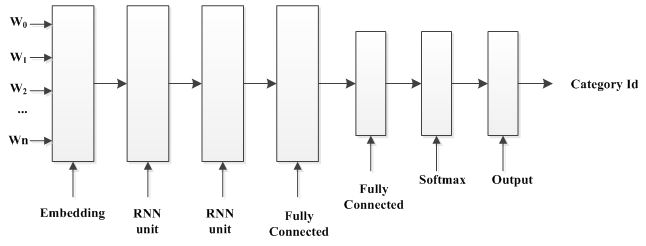

In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super(RNN_net, self).__init__()
        
        # Couche d'embedding pour représenter les mots dans un espace vectoriel
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Couche RNN avec spécifications sur la dimension d'entrée, dimension cachée, nombre de couches, bidirectionnalité, dropout
        self.rnn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        # Couche linéaire pour la première transformation linéaire
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Couche linéaire pour la deuxième transformation linéaire (sortie)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Couche de dropout pour régularisation
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # Appliquer l'embedding aux données textuelles
        embedded = self.embedding(text)
        
        # Ajout du padding
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        # Passer les données emballées à travers la couche RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # Déballer les données pour obtenir le résultat de la couche RNN
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # Concaténer les états cachés de la dernière couche bidirectionnelle
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        # Appliquer la première transformation linéaire, dropout et fonction d'activation ReLU
        output = self.fc1(hidden)
        output = self.dropout(F.relu(output))
        
        # Appliquer la deuxième transformation linéaire pour obtenir la sortie du réseau
        output = self.fc2(output)
        
        return output


In [261]:


class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super(LSTM_net, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
                
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))        
        output = self.fc1(hidden)
        output = self.dropout(F.relu(output))  # Applying ReLU activation
        
        output = self.fc2(output)
        
        return output


In [262]:

class GRU_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super(GRU_net, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.gru = nn.GRU(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, hidden = self.gru(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        output = self.fc1(hidden)
        output = self.dropout(F.relu(output))
        
        output = self.fc2(output)
        
        return output


In [263]:
#creating instance of our LSTM_net class

rnn_model = RNN_net(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT, PAD_IDX)

lstm_model = LSTM_net(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT, PAD_IDX)

gru_model = GRU_net(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT, PAD_IDX)


loading the pretrained vectors into the embedding matrix. 

In [264]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

rnn_model.embedding.weight.data.copy_(pretrained_embeddings)

lstm_model.embedding.weight.data.copy_(pretrained_embeddings)

gru_model.embedding.weight.data.copy_(pretrained_embeddings)


torch.Size([18377, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8220,  0.6198, -0.6535,  ...,  0.8002,  0.1282,  0.0968],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [265]:
#  to initiaise padded to zeros
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
gru_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(rnn_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8220,  0.6198, -0.6535,  ...,  0.8002,  0.1282,  0.0968],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [266]:
rnn_model.to(device)
lstm_model.to(device)
gru_model.to(device)


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)



In [267]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

### Training the model

In [268]:
# training function 
def train(model, optimizer,iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [269]:
from sklearn.metrics import precision_score

def evaluate(model, iterator):
    
    epoch_acc = 0
    epoch_pre = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            binary_predictions = (predictions > 0.5).int()  # Convertir les scores continus en étiquettes binaires
            pre = precision_score(binary_predictions, batch.label)
            
            epoch_acc += acc.item()
            epoch_pre += pre.item()
            
            
        
    return epoch_acc / len(iterator), epoch_pre / len(iterator)

In [270]:
def train_model(model, optimizer, loss, acc, val_acc, val_pre):
    t = time.time()
    for epoch in range(num_epochs):
    
        train_loss, train_acc = train(model, optimizer,train_iterator)
        valid_acc, valid_pre = evaluate(model, valid_iterator)
        print("Epoch ",epoch)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {valid_acc*100:.2f}% | Val. Pre: {valid_pre*100:.2f}% ')
        
        loss.append(train_loss)
        acc.append(train_acc)
        val_acc.append(valid_acc)
        val_pre.append(valid_pre)
        
    print(f'time:{time.time()-t:.3f}')

In [271]:

rnn_loss=[]
rnn_acc=[]
rnn_val_acc=[]
rnn_val_pre = []
train_model(rnn_model, rnn_optimizer, rnn_loss, rnn_acc,rnn_val_acc, rnn_val_pre)

Epoch  0
	Train Loss: 0.662 | Train Acc: 62.99% | Val. Acc: 64.62% | Val. Pre: 0.65% 
Epoch  1
	Train Loss: 0.439 | Train Acc: 81.05% | Val. Acc: 73.68% | Val. Pre: 40.56% 
Epoch  2
	Train Loss: 0.187 | Train Acc: 93.43% | Val. Acc: 75.11% | Val. Pre: 51.97% 
Epoch  3
	Train Loss: 0.093 | Train Acc: 96.74% | Val. Acc: 74.57% | Val. Pre: 50.07% 
Epoch  4
	Train Loss: 0.061 | Train Acc: 97.99% | Val. Acc: 74.14% | Val. Pre: 50.04% 
time:32.994


In [272]:
lstm_loss=[]
lstm_acc=[]
lstm_val_acc=[]
lstm_val_pre = []
train_model(lstm_model, lstm_optimizer, lstm_loss, lstm_acc, lstm_val_acc, lstm_val_pre)

Epoch  0
	Train Loss: 0.517 | Train Acc: 74.43% | Val. Acc: 80.86% | Val. Pre: 62.28% 
Epoch  1
	Train Loss: 0.231 | Train Acc: 91.52% | Val. Acc: 78.94% | Val. Pre: 54.09% 
Epoch  2
	Train Loss: 0.066 | Train Acc: 97.96% | Val. Acc: 78.60% | Val. Pre: 60.38% 
Epoch  3
	Train Loss: 0.026 | Train Acc: 99.13% | Val. Acc: 77.63% | Val. Pre: 61.10% 
Epoch  4
	Train Loss: 0.014 | Train Acc: 99.55% | Val. Acc: 78.04% | Val. Pre: 57.85% 
time:100.438


In [273]:
gru_loss=[]
gru_acc=[]
gru_val_acc=[]
gru_val_pre = []
train_model(gru_model, gru_optimizer, gru_loss, gru_acc, gru_val_acc, gru_val_pre)

Epoch  0
	Train Loss: 0.546 | Train Acc: 74.69% | Val. Acc: 81.00% | Val. Pre: 53.99% 
Epoch  1
	Train Loss: 0.225 | Train Acc: 91.63% | Val. Acc: 75.45% | Val. Pre: 67.63% 
Epoch  2
	Train Loss: 0.064 | Train Acc: 98.09% | Val. Acc: 74.67% | Val. Pre: 69.32% 
Epoch  3
	Train Loss: 0.028 | Train Acc: 99.10% | Val. Acc: 74.55% | Val. Pre: 69.17% 
Epoch  4
	Train Loss: 0.012 | Train Acc: 99.57% | Val. Acc: 76.56% | Val. Pre: 66.33% 
time:81.792


### Plot a graph to trace model performance

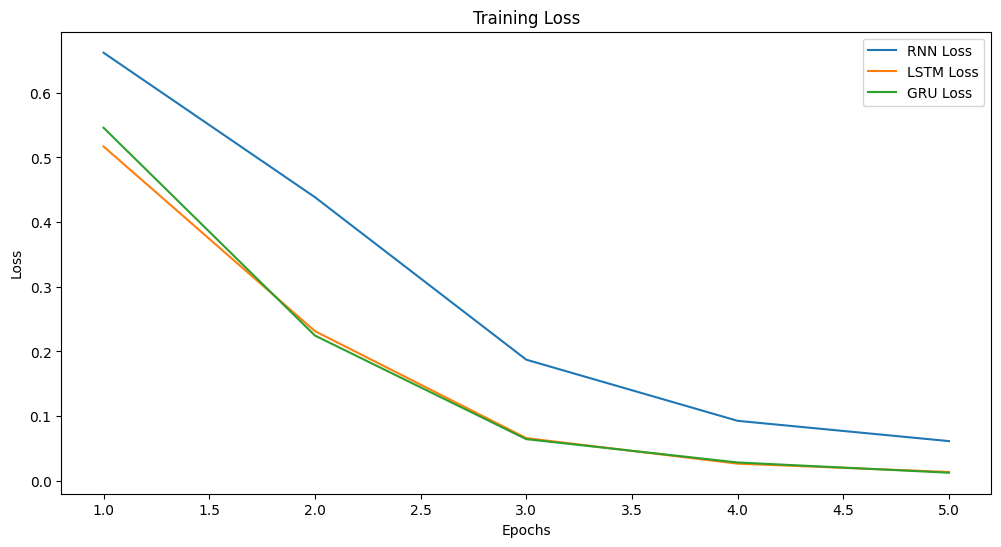

In [274]:
epochs = range(1, len(rnn_loss) + 1)

# Graphique Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, rnn_loss, label='RNN Loss')
plt.plot(epochs, lstm_loss, label='LSTM Loss')
plt.plot(epochs, gru_loss, label='GRU Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

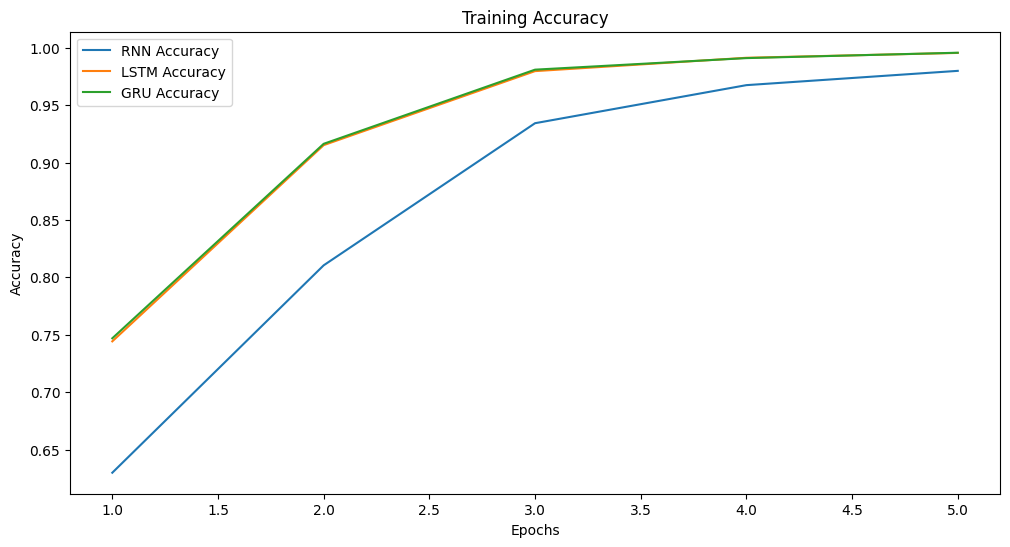

In [275]:
# Graphique Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, rnn_acc, label='RNN Accuracy')
plt.plot(epochs, lstm_acc, label='LSTM Accuracy')
plt.plot(epochs, gru_acc, label='GRU Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

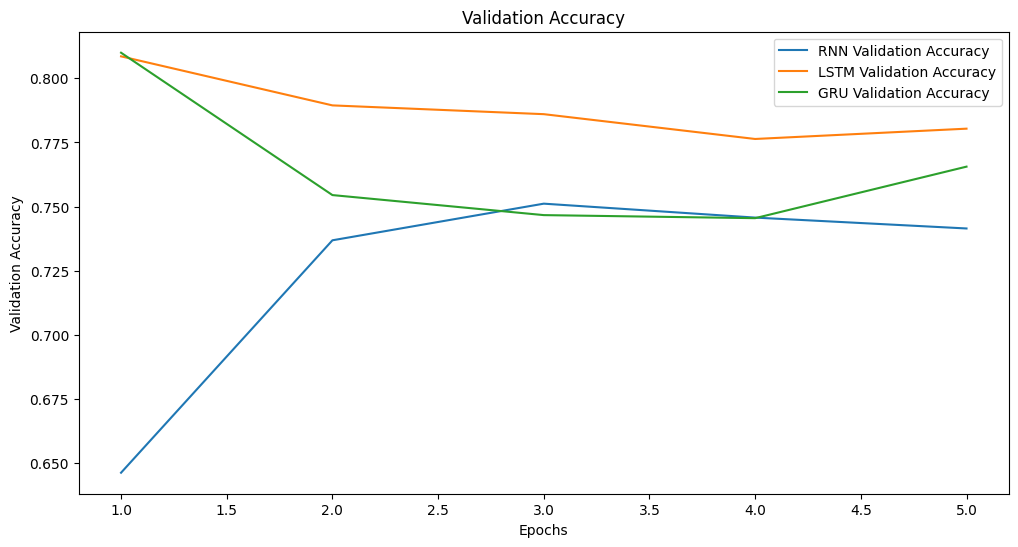

In [276]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, rnn_val_acc, label='RNN Validation Accuracy')
plt.plot(epochs, lstm_val_acc, label='LSTM Validation Accuracy')
plt.plot(epochs, gru_val_acc, label='GRU Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

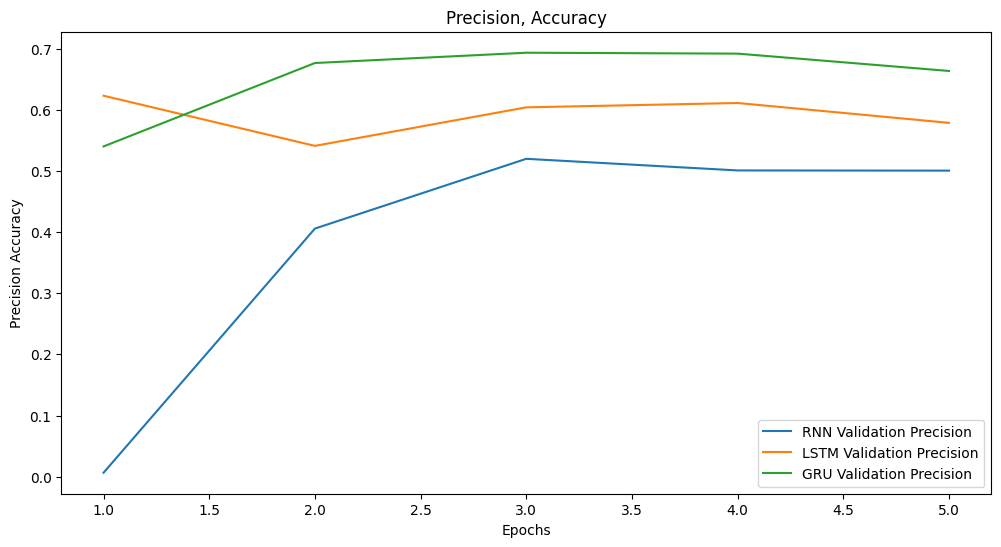

In [277]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, rnn_val_pre, label='RNN Validation Precision')
plt.plot(epochs, lstm_val_pre, label='LSTM Validation Precision')
plt.plot(epochs, gru_val_pre, label='GRU Validation Precision')
plt.title('Precision, Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Precision Accuracy')
plt.legend()
plt.show()